# 순환 신경망으로 IMDB 리뷰 분류하기 (파이토치)

<table align="left"><tr><td>
<a href="https://colab.research.google.com/github/rickiepark/hg-mldl2/blob/main/09-3.pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="코랩에서 실행하기"/></a>
</td></tr></table>

In [1]:
# 실행마다 동일한 결과를 얻기 위해 파이토치에 랜덤 시드를 지정하고 GPU 연산을 결정적으로 만듭니다.
import torch

torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.backends.cudnn.deterministic = True

In [2]:
from keras.datasets import imdb

(train_input, train_target), (test_input, test_target) = imdb.load_data(
    num_words=200)

In [3]:
from sklearn.model_selection import train_test_split

train_input, val_input, train_target, val_target = train_test_split(
    train_input, train_target, test_size=0.2, random_state=42)

In [4]:
from keras.preprocessing.sequence import pad_sequences

train_seq = pad_sequences(train_input, maxlen=100)
val_seq = pad_sequences(val_input, maxlen=100)

In [5]:
train_seq.shape, train_target.shape

((20000, 100), (20000,))

In [6]:
from torch.utils.data import TensorDataset, DataLoader

train_dataset = TensorDataset(torch.tensor(train_seq),
                              torch.tensor(train_target, dtype=torch.float32))
val_dataset = TensorDataset(torch.tensor(val_seq),
                            torch.tensor(val_target, dtype=torch.float32))

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

In [7]:
import torch.nn as nn

class IMDBRnn(nn.Module):
    def __init__(self):
        super().__init__()
        self.embedding = nn.Embedding(200, 16)
        self.rnn = nn.RNN(16, 8, batch_first=True)
        self.dense = nn.Linear(8, 1)
    def forward(self, x):
        x = self.embedding(x)
        _, hidden = self.rnn(x)
        outputs = self.dense(hidden[-1,:,:])
        return outputs

model = IMDBRnn()

In [8]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

IMDBRnn(
  (embedding): Embedding(200, 16)
  (rnn): RNN(16, 8, batch_first=True)
  (dense): Linear(in_features=8, out_features=1, bias=True)
)

In [9]:
import torch.optim as optim

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [10]:
train_hist = []
val_hist = []
patience = 2
best_loss = -1
early_stopping_counter = 0

epochs = 100
for epoch in range(epochs):
    model.train()
    train_loss = 0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets)
            val_loss += loss.item()

    train_loss = train_loss/len(train_loader)
    val_loss = val_loss/len(val_loader)
    train_hist.append(train_loss)
    val_hist.append(val_loss)
    print(f"에포크:{epoch+1},",
          f"훈련 손실:{train_loss:.4f}, 검증 손실:{val_loss:.4f}")

    if best_loss == -1 or val_loss < best_loss:
        best_loss = val_loss
        early_stopping_counter = 0
        torch.save(model.state_dict(), 'best_rnn_model.pt')
    else:
        early_stopping_counter += 1
        if early_stopping_counter >= patience:
            print(f"{epoch+1}번째 에포크에서 조기 종료되었습니다.")
            break

에포크:1, 훈련 손실:0.7435, 검증 손실:0.7243
에포크:2, 훈련 손실:0.7068, 검증 손실:0.7015
에포크:3, 훈련 손실:0.6980, 검증 손실:0.6961
에포크:4, 훈련 손실:0.6957, 검증 손실:0.6942
에포크:5, 훈련 손실:0.6945, 검증 손실:0.6930
에포크:6, 훈련 손실:0.6935, 검증 손실:0.6923
에포크:7, 훈련 손실:0.6926, 검증 손실:0.6915
에포크:8, 훈련 손실:0.6918, 검증 손실:0.6909
에포크:9, 훈련 손실:0.6911, 검증 손실:0.6903
에포크:10, 훈련 손실:0.6906, 검증 손실:0.6899
에포크:11, 훈련 손실:0.6900, 검증 손실:0.6898
에포크:12, 훈련 손실:0.6896, 검증 손실:0.6893
에포크:13, 훈련 손실:0.6891, 검증 손실:0.6891
에포크:14, 훈련 손실:0.6887, 검증 손실:0.6887
에포크:15, 훈련 손실:0.6883, 검증 손실:0.6885
에포크:16, 훈련 손실:0.6879, 검증 손실:0.6882
에포크:17, 훈련 손실:0.6876, 검증 손실:0.6878
에포크:18, 훈련 손실:0.6872, 검증 손실:0.6876
에포크:19, 훈련 손실:0.6869, 검증 손실:0.6875
에포크:20, 훈련 손실:0.6866, 검증 손실:0.6872
에포크:21, 훈련 손실:0.6862, 검증 손실:0.6871
에포크:22, 훈련 손실:0.6859, 검증 손실:0.6868
에포크:23, 훈련 손실:0.6857, 검증 손실:0.6866
에포크:24, 훈련 손실:0.6853, 검증 손실:0.6861
에포크:25, 훈련 손실:0.6851, 검증 손실:0.6859
에포크:26, 훈련 손실:0.6848, 검증 손실:0.6856
에포크:27, 훈련 손실:0.6844, 검증 손실:0.6854
에포크:28, 훈련 손실:0.6840, 검증 손실:0.6852
에포크:29, 훈련 손실:0.6837, 검증 손실:0

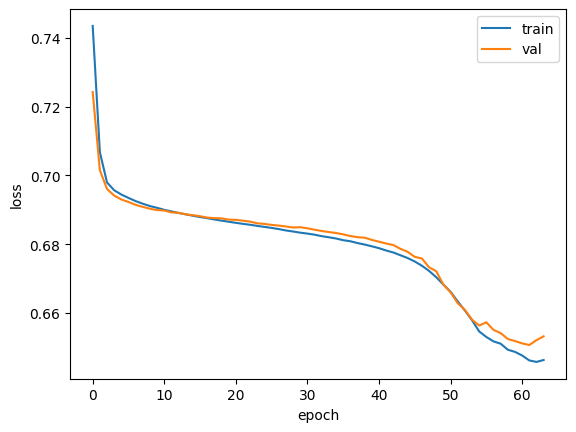

In [11]:
import matplotlib.pyplot as plt

plt.plot(train_hist, label='train')
plt.plot(val_hist, label='val')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

In [12]:
model.load_state_dict(torch.load('best_rnn_model.pt', weights_only=True))

<All keys matched successfully>

In [13]:
model.eval()
corrects = 0
with torch.no_grad():
    for inputs, targets in val_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        predicts = outputs > 0
        corrects += (predicts.squeeze() == targets).sum().item()

accuracy = corrects / len(val_dataset)
print(f"검증 정확도: {accuracy:.4f}")

검증 정확도: 0.6270
